#6. Implement the simple EA for the TSP described in our first lecture (see slides)

a) Implement a variant of this algorithm based on memetic algorithms (MAs). Use
the 2-opt algorithm as local search technique in the memetic algorithm. The
2-opt algorithm tries to swap all pairs of cities to see if this improves the length of the tour (see, e.g. https://en.wikipedia.org/wiki/2-opt).

In [1]:
# Installing a package because taking the algorithm from Wikipedia (see bottommost code cell) is problematically slow.
# This package is about 10 times faster.
!pip install py2opt
from py2opt.routefinder import RouteFinder

  Created wheel for random2: filename=random2-1.0.1-py3-none-any.whl size=12062 sha256=141dee3d8b04c7a38c3a359279918577cb47d9dede7f6a16a116dc3d6ee7c7d6
  Stored in directory: /root/.cache/pip/wheels/88/54/0b/9b1491e11898571fa4b2d4b549ec841a74f16afc807396a5a3
Successfully built random2


In [2]:
# Package made use of assumption that doesn't hold up, have to overwrite the class:
from py2opt.solver import Solver
import random2
import time

class RouteFinder:
    def __init__(self, distance_matrix, cities_names, iterations=5, writer_flag=False, method='py2opt'):
        self.distance_matrix = distance_matrix
        self.iterations = iterations
        self.writer_flag = writer_flag
        self.cities_names = cities_names

    def solve(self):
        start_time = round(time.time() * 1000)
        elapsed_time = 0
        iteration = 0
        best_distance = 0
        best_route = []
        best_distances = []

        while iteration < self.iterations:
            num_cities = len(self.distance_matrix)
            # print(round(elapsed_time), 'msec') # Ugh... print statements that aren't useful... commented out.
            initial_route = [0] + random2.sample(range(1, num_cities), num_cities - 1)
            tsp = Solver(self.distance_matrix, initial_route)
            new_route, new_distance, distances = tsp.two_opt()

            if iteration == 0:
                best_distance = new_distance
                best_route = new_route
            else:
                pass

            if new_distance < best_distance:
                best_distance = new_distance
                best_route = new_route
                best_distances = distances

            elapsed_time = round(time.time() * 1000) - start_time
            iteration += 1

        # if self.writer_flag:
        #     self.writer(best_route, best_distance, self.cities_names)

        if all(self.cities_names): # tbh I don't understand why there's an if(array) here in the first place.
            best_route = [self.cities_names[i] for i in best_route]
            return best_distance, best_route
        else:
            return best_distance, best_route

    ## staticmethod
    # def writer(best_route, best_distance, cities_names):
    #     f = open("../results.txt", "w+")
    #     for i in best_route:
    #         f.write(cities_names[i])
    #         f.write("\n")
    #         print(cities_names[i])
    #     f.write(str(best_distance))
    #     f.close()

In [3]:
import math
from numpy import random
import numpy as np

### Helper code. Algorithm below.

class City:
  def __init__(self, id, x, y):
    self.id = id
    self.x = float(x)
    self.y = float(y)

  @staticmethod
  def distance(city1, city2):
    return math.sqrt((city1.x - city2.x)**2+(city1.y - city2.y)**2)

def convert_string_to_cities(string):
  cities = []
  for i,line in enumerate(string.splitlines()):
    coords=line.split()
    city = City(i,coords[0],coords[1])
    cities.append(city)
  return cities

def initialize_population(coords, pop_size):
  cities = np.array(convert_string_to_cities(coords))
  population = []
  for i in range(pop_size):
    one = random.permutation(cities)
    population.append(one)
  return population

def tour_length(tour):
  # A tour is assumed to be a list of city objects.
  distance = 0
  for index,city in enumerate(tour):
    if(index<len(tour)-1):
      distance = distance + City.distance(city,tour[index+1])
  return distance

def select_parents_binary_tournament(population):
  # Assuming fixed population size and 2 parents -> 2 offspring:
  parents_needed = len(population)
  selected_parents = []
  while(len(selected_parents)<parents_needed):
    # From two random individuals in the population, pick the best (assuming individuals don't have to be unique)
    contestants = np.random.default_rng().choice(population,2)
    if tour_length(contestants[0])<tour_length(contestants[1]):
      selected_parents.append(contestants[0])
    else:
      selected_parents.append(contestants[1])
  return selected_parents

def crossover_parents(p1, p2):
  # | 0 1 1 | #
  # v       |
  # cutting point [0]
  #         v
  # cutting point [len(p)]
  #----
  # Current code assumes at least 1 gene will get copied. It also assumes that '0' is never a valid gene.
  cutting_point_1 = np.random.randint(0, len(p1)-1)
  cutting_point_2 = np.random.randint(cutting_point_1+1, len(p1)+1) # len(p)+1 because randint is exclusive

  c1 = np.zeros(len(p1)).tolist()
  c2 = np.zeros(len(p1)).tolist()
  # Keep track of cities already assigned to avoid duplicates
  cities_in_c1 = []
  cities_in_c2 = []

  # Copy between cutting points to offspring
  for i in range (cutting_point_1, cutting_point_2):
    c1[i] = p1[i]
    cities_in_c1.append(p1[i])
    c2[i] = p2[i]
    cities_in_c2.append(p2[i])

  c1 = __crossover_helper__(c1, p2, cities_in_c1,cutting_point_1,cutting_point_2)
  c2 = __crossover_helper__(c2, p1, cities_in_c2,cutting_point_1,cutting_point_2)
  return c1, c2

def __crossover_helper__(child, other_parent, cities_in_child, cut_1, cut_2):
  # Fill rest of positions (if applicable)
  if(cut_2<len(other_parent)):
    for i in range(cut_2, len(other_parent)):
      if other_parent[i] not in cities_in_child:
        child[i] = other_parent[i]
        cities_in_child.append(other_parent[i])
      else:
        j = i #Because we iterate over parent's indices j to fill in child's index i
        while(child[i]==0):
          # Try the next position in parent if that is still within bounds,
          if j+1 < len(other_parent):
            j = j+1
            if other_parent[j] not in cities_in_child:
              child[i] = other_parent[j]
              cities_in_child.append(other_parent[j])
          # Otherwise start from beginning of other parent
          else:
            j = 0
            if other_parent[j] not in cities_in_child:
              child[i] = other_parent[j]
              cities_in_child.append(other_parent[j])
            else:
              j = j+1
  if cut_1>0:
    for i in range(0, cut_1):
      if other_parent[i] not in cities_in_child:
        child[i] = other_parent[i]
        cities_in_child.append(other_parent[i])
      else:
        j = i #Because we iterate over parent's indices j to fill in child's index i
        while(child[i]==0):
          j = j+1
          if other_parent[j] not in cities_in_child:
            child[i] = other_parent[j]
            cities_in_child.append(other_parent[j])
  return child

def mutate(child):
  # Note: it is possible that a mutation swaps the same position with itself. In that case, nothing happens.
  mutation_pos_1 = np.random.randint(0, len(child)-1)
  mutation_pos_2 = np.random.randint(0, len(child)-1)
  pos1_val = child[mutation_pos_1]
  pos2_val = child[mutation_pos_2]
  child[mutation_pos_1] = pos2_val
  child[mutation_pos_2] = pos1_val
  return child

def dist_mat(coords):
  cities = np.array(convert_string_to_cities(coords))
  matrix = [[City.distance(city1,city2) for city1 in cities] for city2 in cities]
  return matrix

## Some tests:

# cities = np.array(convert_string_to_cities(burma))
# for i in range(1):
#   one = random.permutation(cities)
#   print(tour_length(one))

# initial = initialize_population(burma, 4)
# print(initial)
# print("------")
# selected = select_parents_binary_tournament(initial)
# print(selected)

# # If you hardcode the cut points at 2 and 6 you can replicate the example from the slides.
# p1 = [3, 5, 7, 2, 1, 6, 4, 8]
# p2 = [2, 5, 7, 6, 8, 1, 3, 4]
# c1, c2 = crossover_parents(p1,p2)
# print(c1)
# print(c2)

In [7]:
## Algorithm here ##

iters = 1500
# iters = 5 # Useful for fast testing
pop_size = 4  # NOTE: only even numbers
mutation_prob = 0.05

def evolutionary_TSP(max_iter, coords, is_memetic):
  distances = []
  if is_memetic:
    distances = dist_mat(coords)
  quality_over_time = []
  population = initialize_population(coords, pop_size)
  if is_memetic:
    optimized_population = []
    for tour in population:
      route_finder = RouteFinder(distances, tour, iterations=1)
      _ , tour = route_finder.solve()
      optimized_population.append(tour)
    population = optimized_population
  quality = [1/tour_length(tour) for tour in population]
  quality_over_time.append(quality)
  for gen in range(max_iter):
    selected = select_parents_binary_tournament(population)
    children = []
    while(len(children)<len(selected)):
      parents = np.random.default_rng().choice(selected,2)
      firstchild, secondchild = crossover_parents(parents[0], parents[1])
      children.append(firstchild)
      children.append(secondchild)
    for child in children:
      rand = np.random.random(1)
      if rand<mutation_prob:
        child = mutate(child)
    if is_memetic:
      optimized_population = []
      for tour in population:
        route_finder = RouteFinder(distances, tour, iterations=1)
        _ , tour = route_finder.solve()
        optimized_population.append(tour)
      population = optimized_population
    population = children
    quality = [1/tour_length(tour) for tour in population]
    quality_over_time.append(quality)
    # Considering fixed population size, assume that all children are passed on
  return quality_over_time

# ## Tests:
# results = evolutionary_TSP(iters, burma, False)
# max_per_gen = np.amax(results,1).tolist()
# print(results)
# print(max_per_gen)

b) Consider the TSP problem instance given in the file `file-tsp'. The file `file-
tsp' contains a 50  2 matrix with the coordinates (xi; yi) for city i = 1,...,50.

Also, select a small instance at your choice from the `Symmetric Traveling Salesman Problem' benchmark instances available at http://elib.zib.de/pub/
mp-testdata/tsp/tsplib/tsplib.html. Run the MA and EA 10 times on
these two problem instances.

In [8]:
# Chosen 'small instance': http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/burma14.tsp
burma = """16.47       96.10
16.47       94.44
20.09       92.54
22.39       93.37
25.23       97.24
22.00       96.05
20.47       97.02
17.20       96.29
16.30       97.38
14.05       98.12
16.53       97.38
21.52       95.59
19.41       97.13
20.09       94.55"""
tsp = ""
with open("file-tsp.txt") as file:
  tsp = file.read()

runs_EA_burma = []
for run in range(10):
  runs_EA_burma.append(evolutionary_TSP(iters, burma, False))

runs_EA_tsp = []
for run in range(10):
  runs_EA_tsp.append(evolutionary_TSP(iters, tsp, False))

runs_MA_burma = []
for run in range(10):
  runs_MA_burma.append(evolutionary_TSP(iters, burma, True))

runs_MA_tsp = []
for run in range(10):
  runs_MA_tsp.append(evolutionary_TSP(iters, tsp, True))

c) For each algorithm (EA and MA), and for each problem instance, provide a
figure containing plots average and best  tness against the elapsed number of
iterations (1500 iterations) for all 10 runs.

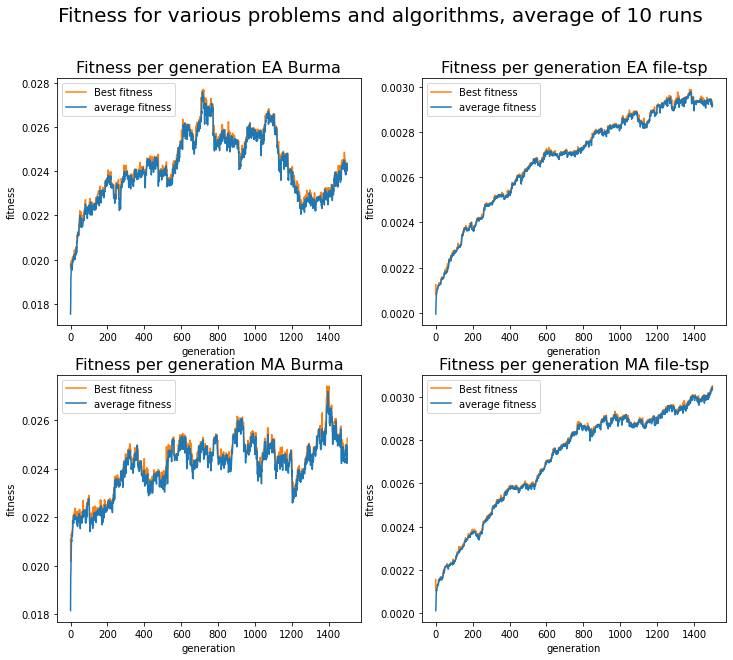

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize = (12,10))
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=20)
fig.suptitle("Fitness for various problems and algorithms, average of 10 runs")
x = np.arange(iters+1)

axs[0,0].set_title("Fitness per generation EA Burma")
max_runs = np.amax(runs_EA_burma,2).tolist()
avg_runs = np.average(runs_EA_burma,2).tolist()
axs[0,0].plot(x,np.average(max_runs,0), color='tab:orange', label = 'Best fitness')
axs[0,0].plot(x,np.average(avg_runs,0), color='tab:blue', label = 'average fitness')
axs[0,0].legend()

axs[0,1].set_title("Fitness per generation EA file-tsp")
max_runs = np.amax(runs_EA_tsp,2).tolist()
avg_runs = np.average(runs_EA_tsp,2).tolist()
axs[0,1].plot(x,np.average(max_runs,0), color='tab:orange', label = 'Best fitness')
axs[0,1].plot(x,np.average(avg_runs,0), color='tab:blue', label = 'average fitness')
axs[0,1].legend()

axs[1,0].set_title("Fitness per generation MA Burma")
max_runs = np.amax(runs_MA_burma,2).tolist()
avg_runs = np.average(runs_MA_burma,2).tolist()
axs[1,0].plot(x,np.average(max_runs,0), color='tab:orange', label = 'Best fitness')
axs[1,0].plot(x,np.average(avg_runs,0), color='tab:blue', label = 'average fitness')
axs[1,0].legend()

axs[1,1].set_title("Fitness per generation MA file-tsp")
max_runs = np.amax(runs_MA_tsp,2).tolist()
avg_runs = np.average(runs_MA_tsp,2).tolist()
axs[1,1].plot(x,np.average(max_runs,0), color='tab:orange', label = 'Best fitness')
axs[1,1].plot(x,np.average(avg_runs,0), color='tab:blue', label = 'average fitness')
axs[1,1].legend()

for ax in axs.flat:
  ax.set(xlabel="generation", ylabel="fitness")


## Note: if max and average should be visible for each of the 10 runs separately, use code below. NOTE: very cluttered.
# for run in max_runs:
#   axs[0,0].plot(x,run, color='tab:orange')
# for run in avg_runs:
#   axs[0,0].plot(x,run, color='tab:blue')

d) Compare the plots of the two algorithms. Which method (EA or MA) works
best?

The results are highly similar, both in final fitness values and in the speed of convergence. I was expecting MA to converge faster as each candidate should be locally optimal, but I don't see that happening in the plots. Based on this, I can't say which works best.

e) Do you consider the above comparison of the MA and EA algorithms (based on
their results over the same number of iterations) fair? Justify your answer. If
your answer is no, then explain what a fair comparison could be.

Not sure. While the number of iterations is the same, MA requires a lot more calculations per iteration. A fairer comparison might give them the same amount of time or computational resources, regardless of the number of iterations.

f) In general, on the TSP problem, are memetic algorithms more effective than
simple EAs? (To answer this question, please rely on (recent) results from the
literature, and include references to the papers used to answer this question).

Generally, memetic algorithms perform better on the TSP problem.
(For references, please refer to the pdf.)

In [ ]:
## two_opt as directly adapted from Wikipedia. VERY slow. Took half a minute on 5 generations. Oof. 
## Keeping here only in case we don't trust the imported package.

# def two_opt(tour):
#   # Directly adapted from https://en.wikipedia.org/wiki/2-opt
#   best_distance = tour_length(tour)
#   for i in range(len(tour)):
#     for k in range(1,len(tour)):
#       new_route = __two_opt_swap__(tour, i, k)
#       new_distance = tour_length(new_route)
#       if new_distance < best_distance:
#         tour = new_route
#         best_distance = new_distance
#   return tour

# def __two_opt_swap__(tour, i, k):
#   new_route = []
#   # 1. take route[0] to route[i-1] and add them in order to new_route
#   for index in range (i):
#     new_route.append(tour[index])
#   # 2. take route[i] to route[k] and add them in reverse order to new_route
#   for index in reversed(range(i,k+1)):
#     new_route.append(tour[index])
#   # 3. take route[k+1] to end and add them in order to new_route
#   for index in range (k+1,len(tour)):
#     new_route.append(tour[index])
#   return new_route